# Quest for lattice symmetries.

This notebook allows us to study the rotation symmetries of the 2x2x2 Gauss lattice. The logic for the transformations is coded in `lattice_object.py`, which contains a class `LatticeObject` that represents a given lattice configuration.

In [249]:
import numpy as np
from matplotlib import cm 
import matplotlib.pyplot as plt
%matplotlib inline

from lattice_object import LatticeObject

#### Basis lattices.
These latttice configurations are the ones with the maximum number of flippable plaquettes, i.e., `16` for a `2 x 2 x 2` system, of which there are `12`.

In [22]:
lattices = np.array([ 
    3816540,  
    3872106,  
    5421780,
    5678001,  
    7542990,  
    7743645,  
    9033570,  
    9234225, 
    11099214, 
    11355435, 
    12905109,
    12960675
])

#### Example usage.
This is merely to illustrate the usage of the object. We take one of the basis states and rotate it along the axis $C_3^0$. The convention is that this refers to the $0$-th axis with a $3$-fold symmetry.

Setting up lattice 3816540
|001110100011110001011100> (3816540)
# of flippable plaquettes: 16
---
|010101101010001110110001> (5678001)
# of flippable plaquettes: 16


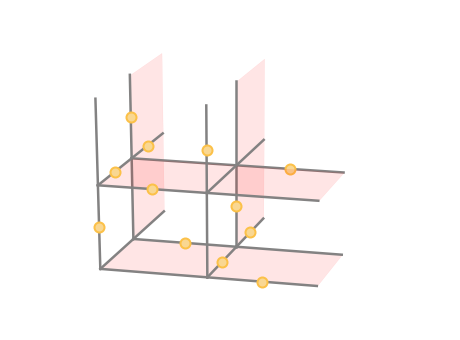

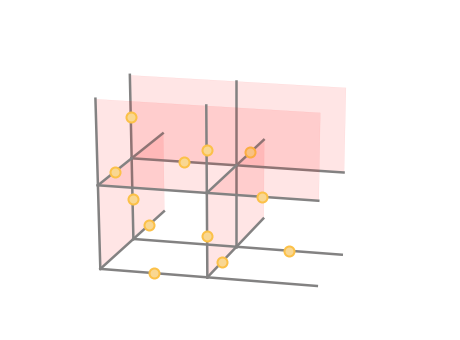

In [4]:
# Create lattice object with the first lattice of the above list. We could have used any other integer.
latt = LatticeObject(lattices[0], [2,2,2])

# Print some information.
print(latt.to_bin()) # Binary represenation.
latt.draw() # 3D drawing.
print('---')

# Perform rotation.
latt.apply_c3(axis=0, steps=2)

# Print informatioun again.
print(latt.to_bin())
latt.draw()

## Table of simple operations.
Here we produce a table of several simple operations to see how the states transform.

In [5]:
class LatticeBasis(object):
    """ Represents a collection of lattices.
    """
    def __init__(self, L=[2,2,2]):
        if L==[2,2,2]:
            self.lattices = np.array([
                3816540, 
                3872106,  
                5421780, 
                5678001, 
                7542990,  
                7743645,  
                9033570,  
                9234225, 
                11099214, 
                11355435, 
                12905109, 
                12960675 
            ])
        else:
            raise KeyError('Specified lattice not available.')
   

    def make_operator(self, op, quiet=False):
        """ Generates the operator as a list of indicies where 
            the i-th index maps to the entry at position i.
        """ 
        if not quiet:
            print(op)
        mlist = np.empty(shape=(len(self.lattices)), dtype=int)
        for init, state in enumerate(self.lattices):
            latt = LatticeObject(state, [2,2,2], quiet=True)
            if op.name == 'P':
                latt.apply_parity_flip()
            elif op.name == 'CC':
                latt.apply_charge_conjugation()
            elif op.name.startswith('C_2'):
                latt.apply_c2(op.args, steps=op.steps)
            elif op.name.startswith('C_3'):
                latt.apply_c3(op.args, steps=op.steps)
            elif op.name.startswith('C_4'):
                latt.apply_c4(op.args, steps=op.steps)
            elif op.name.startswith('T'):
                for step in op.args:
                    latt.apply_translation(axis=op.args, extent=1)
            else:
                raise KeyError('Unknown operator specified.')
                
            # Find which state we produced.
            try:
                final = np.where(self.lattices == latt.to_int())[0][0]
            except IndexError:
                final = np.nan
                
            # Map.
            mlist[init] = final
            
            # Print the result.
            if not quiet:
                print('{:2s} |{:2d}> = |{:2d}>'.format(op.name, init+1, final+1))
        return mlist
    
    
    def make_operator_batch(self, operations, latex_output=False, quiet=True, **kwargs):
        op_map = np.zeros(shape=(len(operations),len(self.lattices)), dtype=int) - 1
        for i, op in enumerate(operations):
            op_map[i,:] = self.make_operator(op, quiet=quiet)
            
        if latex_output:
            return self._to_table(op_map, list(map(lambda o: o.name, operations)), **kwargs)
        return op_map

        
    @staticmethod
    def _to_table(entries, ops, lpf=None):
        """ Takes a 2D array and produces the bulk of a table for latex.
        """
        ket = lambda s:  '\\ket{'+s+'}' if lpf is None else '\\ket{'+lpf+'_{'+s+'}}'
        conv = lambda x: '---' if x < 0 else '$'+ket(str(x))+'$' 
        rows, cols = np.shape(entries.T)

        # Header.
        print('\\begin{tabular}{c|' + 'c'*cols + '}')
        print('\\hline')
        op_line = '  $'+ket('n')+'$ &'
        for j in range(cols):
            op_line += '$' + ops[j] + '$  & '
        print(op_line[:-2] + ' \\\\')
        print('\\hline')

        # Bulk.
        for i in range(rows):
            print('  $'+ket(str(i+1))+'$ & ' + ' & '.join(map(conv, entries[:,i]+1)) + ' \\\\')

        # Fin.
        print('\\hline')
        print('\\end{tabular}')
        
class Operation(object):
    def __init__(self, name, args, steps=1):
        self.name = name
        self.args = args
        self.steps = steps
        
    def __repr__(self):
        return "Operation {0} [{1} // {2} steps].".format(self.name, self.args, self.steps)
        
operations = [
    Operation('T_{x}', [0]),
    Operation('T_{y}', [1]),
    Operation('T_{z}', [2]),
    Operation('T_{xy}', [0,1]),
    Operation('T_{xz}', [0,2]),
    Operation('T_{yz}', [1,2]),
    Operation('T_{xyz}', [0,1,2]),
    Operation('P', []),
    Operation('CC', [])
]

lb = LatticeBasis(L=[2,2,2])block_diag
lb.make_operator_batch(operations, quiet=True, latex_output=False, lpf=None)

array([[11, 10,  6,  8,  7,  9,  2,  4,  3,  5,  1,  0],
       [ 7, 10,  9,  8, 11,  6,  5,  0,  3,  2,  1,  4],
       [11,  3,  9,  1,  7,  6,  5,  4, 10,  2,  8,  0],
       [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11],
       [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11],
       [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11],
       [ 7,  3,  6,  1, 11,  9,  2,  0, 10,  5,  8,  4],
       [ 7,  3,  6,  1, 11,  9,  2,  0, 10,  5,  8,  4],
       [11, 10,  9,  8,  7,  6,  5,  4,  3,  2,  1,  0]])

In [330]:
from scipy.linalg import block_diag
from copy import copy
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

class GSManifold(object):
    """ Holds the states for the GS manifold so that we can investigate them.
    """
    def __init__(self, state_file, L=[2,2,2]):
        # These are the 12 lowest eigenstates.
        self.eigenstates = np.load(state_file)
        self.lattice_base = LatticeBasis(L)
        
        # These are the energy manifolds.
        self.manifolds = {
            'E0' : [1],
            'E1' : [2,3],
            'E2' : [4,5,6],
            'E3' : [7,8,9],
            'E4' : [10,11],
            'E5' : [12]
        }
    def _make_operator(self, *args, **kwargs):
        return self.lattice_base.make_operator(*args, **kwargs)
    
    def _to_table(*args, **kwargs):
        return self.lattice_base._tot
    
    def _get_states(self, eigenstates):
        if eigenstates is None:
            return self.eigenstates
        else:
            return self.eigenstates[:,np.atleast_1d(eigenstates)-1]
    
    def apply_operator(self, op, eigenstates=None):
        """ Applies a signle operator to a list of eigenstates. If no 
            states arespecified, the operator will be applied to all states. 
        """
        states = self._get_states(eigenstates)
        operator = self._make_operator(op, quiet=True)
        new_states = np.array([s[operator] for s in states])
        return new_states
    
    def get_matrix(self, op, substates=None):
        """ Takes an operation and possibly a list of substates (by number 1-12). The matrix
            represenation in the specified subspace is returned.
        """
        # Shift to index.
        if substates:
            substates = np.array(substates)-1
        else:
            substates = np.array(list(range(self.eigenstates.shape[-1])))
        subspace = self.eigenstates[:,substates]
        
        # Make the operator.
        operator = self._make_operator(op, quiet=True)
        
        # Produce matrix.
        M = np.empty(shape=(len(substates),len(substates)), dtype=np.complex128)
        for i in range(len(substates)):
            for j in range(len(substates)):
                final = subspace[:,i][operator]        
                M[i,j] = np.dot(subspace[:,j], final)
        return M
    
    
    def diagonalize_operator(self, op):
        """ Returns a set of eigenvalues and eigenstates that diagonalize both the Hamiltonian 
            (which is in fact trivial, since we build those from energy eigenstates) and the 
            operator in question.
        """
#         O = np.zeros_like(self.eigenstates)
        O = []
        for _, man in self.manifolds.items():
            M = self.get_matrix(op, substates=man)
            ev, es = np.linalg.eig(M)
            B = np.dot(np.dot(np.conj(es.T), M), es)
            O.append(B)
        return self.get_matrix(op), block_diag(*O)

### Check several operators.

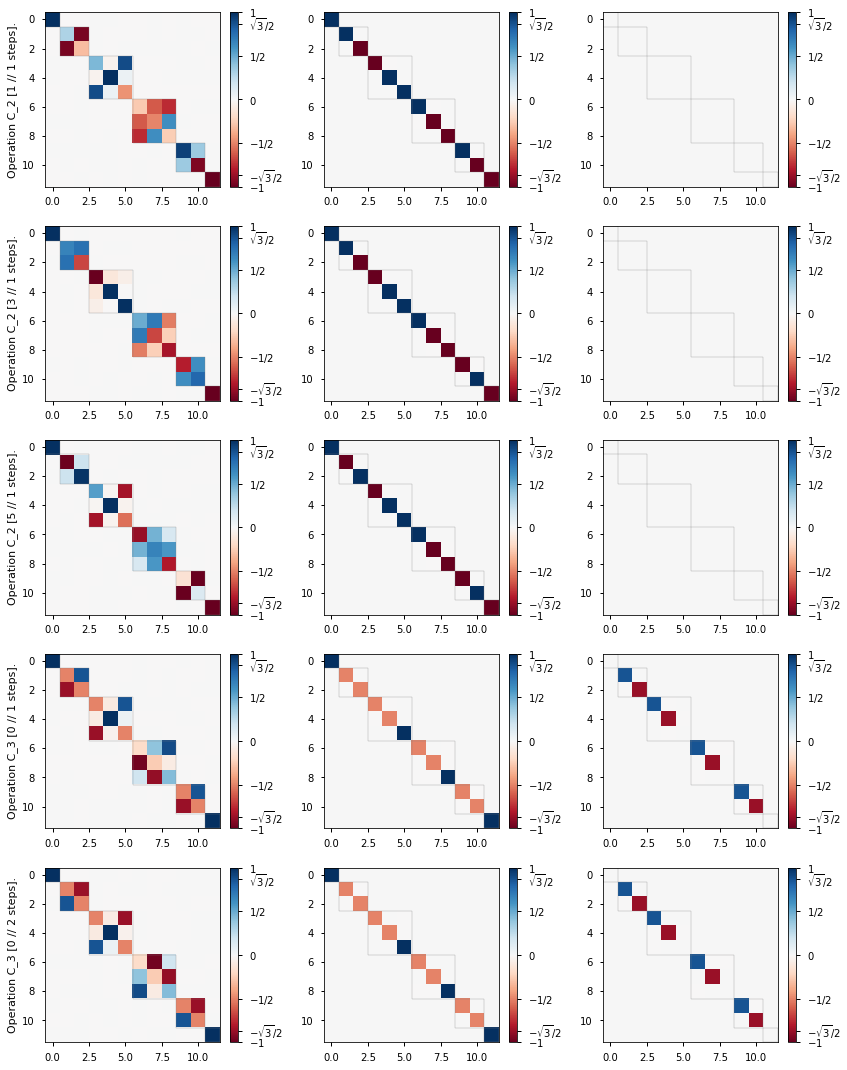

In [332]:
def draw_matrices(m_list, axes=None, fig=None):
    ax = axes
    if axes is None:
        fig, ax = plt.subplots(1,len(m_list))
        fig.set_size_inches(4*len(m_list),4)
    else:
        ax = axes
    
    for i,M in enumerate(m_list):
        im = ax[i].imshow(M, cmap=cm.RdBu)
        im.set_clim(-1,1)
        cbar = fig.colorbar(im, ax=ax[i],fraction=0.046, pad=0.04)
        cbar.set_ticks([-1, -np.sqrt(3)/2, -0.5, 0, 0.5, np.sqrt(3)/2, 1])
        cbar.set_ticklabels(['$-1$', '$-\\sqrt{3}/2$', '$-1/2$', '$0$', '$1/2$', '$\\sqrt{3}/2$', '$1$'])
        
    # Draw the rectangles.
    rectangles = [
        [(-0.5,-0.5),1,1],
        [(0.5,0.5),2,2],
        [(2.5,2.5),3,3],
        [(5.5,5.5),3,3],
        [(8.5,8.5),2,2],
        [(10.5,10.5),1,1],
    ] 
    pc = PatchCollection(
        list([Rectangle(*r) for r in rectangles]), 
        facecolor='none',
        edgecolor='gray'
    )
    for a in ax.flatten():
        a.add_collection(copy(pc))
#     for a in ax.flatten():
#         a.add_collection(pc)

    if axes is None:
        return fig, ax
    

gsm = GSManifold('eigenstates_bosons_2x2x2_lam-100.00.npy')

operations = [
    Operation('C_2', 1, 1),
    Operation('C_2', 3, 1),
    Operation('C_2', 5, 1),
    Operation('C_3', 0, 1),
    Operation('C_3', 0, 2),
]

with plt.style.context('seaborn-notebook'):
    fig, ax = plt.subplots(len(operations), 3, squeeze=False)
    fig.set_size_inches(12, 3*len(operations))
    
    for i, op in enumerate(operations):
        M, O = gsm.diagonalize_operator(op)
        draw_matrices([M.real, O.real, O.imag], axes=ax[i,:], fig=fig)
        ax[i,0].set_ylabel(str(op))
        
    fig.tight_layout()
    fig.savefig('../../notes_overleaf/img/operator_diagonalization.pdf')

### Compare the matrices for different $\lambda$.

Operation C_2 [1 // 1 steps].


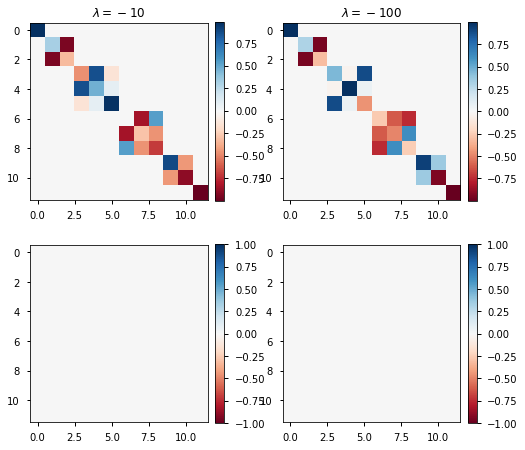

In [227]:
operation = Operation('C_2', 1, 1)
gsm10 = GSManifold('eigenstates_bosons_2x2x2_lam-10.00.npy')
gsm100 = GSManifold('eigenstates_bosons_2x2x2_lam-100.00.npy')
gsminf = GSManifold('eigenstates_bosons_2x2x2_lam-inf.npy')

M = {
    -10: gsm10.get_matrix(operation),
    -100: gsm100.get_matrix(operation),
#     '-inf' : gsminf.get_matrix(operation)
}

with plt.style.context('seaborn-notebook'):
    fig, ax = plt.subplots(2,len(M), squeeze=False)
    fig.set_size_inches(4*len(M),7.5)
    
    for i, lam in enumerate(M):
        cbar = ax[0,i].imshow(M[lam].real, cmap=cm.RdBu)
        fig.colorbar(cbar, ax=ax[0,i],fraction=0.046, pad=0.04)
        
        cbar = ax[1,i].imshow(M[lam].imag, cmap=cm.RdBu)
        fig.colorbar(cbar, ax=ax[1,i],fraction=0.046, pad=0.04)
        cbar.set_clim(-1,1)
        
        ax[0,i].set_title('$\\lambda = {:s}$'.format(str(lam)))
        
    fig.subplots_adjust(wspace=0.3, hspace=0.2)
#     fig.text(0.145, 0.22, operation, fontsize=12)
    print(operation)

## Batch processing of all sub-structures.

Operation C_2 [1 // 1 steps] on manifold [10, 11].
[ 0.99995278+0.j -0.99995278+0.j]
Operation C_2 [3 // 1 steps] on manifold [10, 11].
[-0.99995278+0.j  0.99995278+0.j]
Operation C_2 [5 // 1 steps] on manifold [10, 11].
[-0.99995278+0.j  0.99995278+0.j]
Operation C_3 [0 // 1 steps] on manifold [10, 11].
[-0.49997639+0.86598451j -0.49997639-0.86598451j]
Operation C_3 [0 // 2 steps] on manifold [10, 11].
[-0.49997639+0.86598451j -0.49997639-0.86598451j]


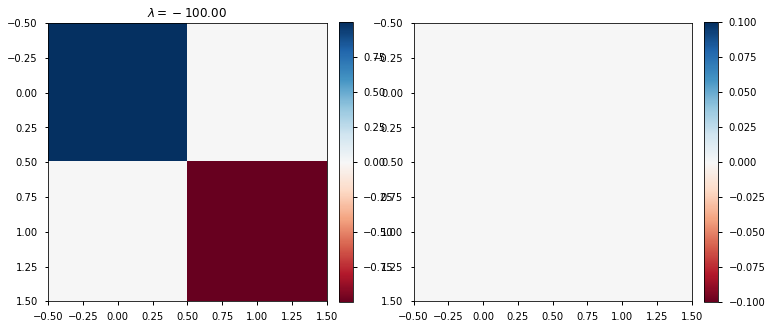

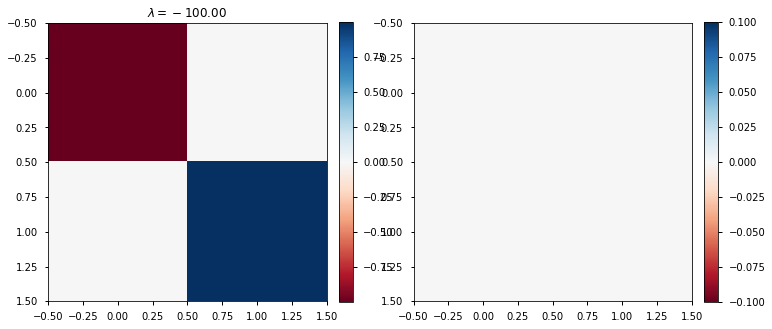

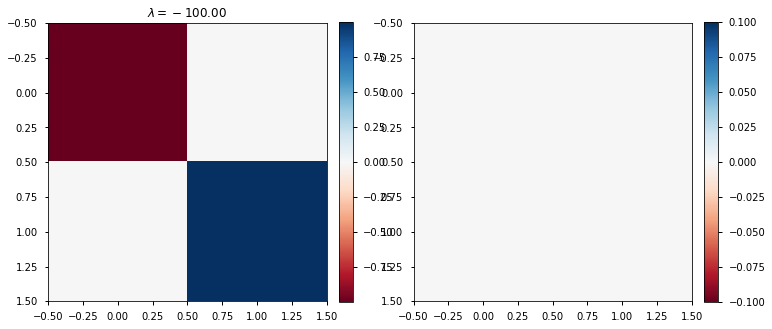

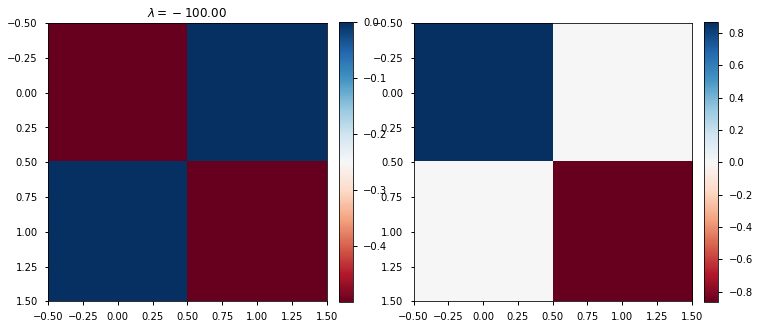

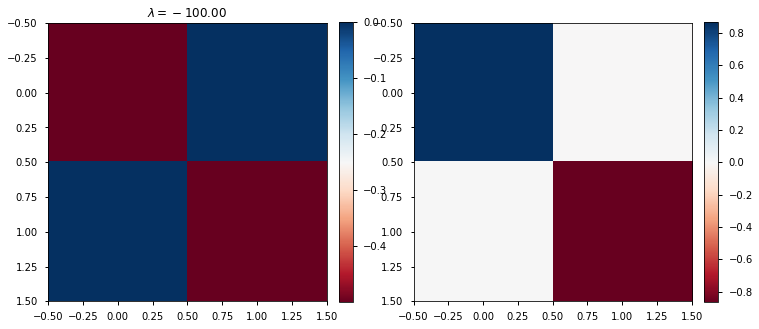

In [235]:
operations = [
    Operation('C_2', 1, 1),
    Operation('C_2', 3, 1),
    Operation('C_2', 5, 1),
    Operation('C_3', 0, 1),
    Operation('C_3', 0, 2),
]

manifolds = {
    'E1' : [2,3],
    'E2' : [4,5,6],
    'E3' : [7,8,9],
    'E4' : [10,11]
}

for op in operations:

    # Make the matrix.
    man = manifolds['E4']
    gsm = GSManifold('eigenstates_bosons_2x2x2_lam-100.00.npy')
    M = gsm.get_matrix(op, substates=man)

    # Get eigenvalues/vectgos.
    ev, es = np.linalg.eig(M)
    B = np.dot(np.dot(np.conj(es.T), M), es)

    with plt.style.context('seaborn-notebook'):
        fig, ax = plt.subplots(1,2, squeeze=False)
        fig.set_size_inches(12,6)


        cbar = ax[0,0].imshow(B.real, cmap=cm.RdBu)
        fig.colorbar(cbar, ax=ax[0,0],fraction=0.046, pad=0.04)

        cbar = ax[0,1].imshow(B.imag, cmap=cm.RdBu)
        fig.colorbar(cbar, ax=ax[0,1],fraction=0.046, pad=0.04)

        ax[0,0].set_title('$\\lambda = {:.2f}$'.format(lam))
        print('{:s} on manifold {:s}.'.format(str(op)[:-1], str(man)))
        print(ev)
